In [1]:
import nomic
import json
api_key_path = "/home/ubuntu/api_keys.json"

with open(api_key_path, 'r') as j:
    key = json.loads(j.read())['nomic']

nomic.login(key)

from nomic import AtlasDataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

dataset = AtlasDataset('hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-05-29')

embds = dataset.maps[0].embeddings.latent
df = dataset.maps[0].data.df

2024-05-30 23:27:49.887 | INFO     | nomic.dataset:__init__:829 - Loading existing dataset `hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-05-29`.
100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 21285.02it/s]


In [2]:
congress_persons, tweets_per_congress_person = np.unique(list(df['twitter_lower']), return_counts=True)
congress_persons = list(congress_persons)

average_embds = np.zeros((len(congress_persons), embds.shape[1]))
party_by_congress_person = [-1 for cp in congress_persons]

for i, embd in enumerate(tqdm(embds)):
    congress_person_index = congress_persons.index(df['twitter_lower'][i])
    average_embds[congress_person_index] += embd

    if party_by_congress_person[congress_person_index] == -1:
        party_by_congress_person[congress_person_index] = df['party'][i].lower()

average_embds = np.divide(average_embds, tweets_per_congress_person.reshape(-1, 1))
unique_party_labels, party_counts = np.unique(party_by_congress_person, return_counts=True)

100%|██████████████████████████████████████████████████████████████████████| 3037316/3037316 [01:41<00:00, 29797.36it/s]


/home/ubuntu/venvs/pnma/lib/python3.8/site-packages/graspologic/models/edge_swaps.py:215: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  _edge_swap_numba = nb.jit(_edge_swap, nopython=False)


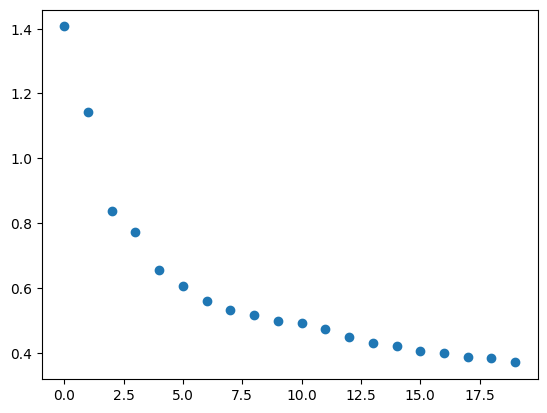

In [3]:
from graspologic.embed import ClassicalMDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

CMDS = ClassicalMDS(n_components=20)
cmds_embds = CMDS.fit_transform(average_embds)
singular_values = CMDS.singular_values_

CMDS = ClassicalMDS()
cmds_embds = CMDS.fit_transform(average_embds)

LDA = LinearDiscriminantAnalysis()
LDA.fit(cmds_embds, party_by_congress_person)
lda_embds = LDA.transform(cmds_embds)

colors = {
    'd': 'b',
    'r': 'r',
    'i': 'g'
         }

fig, ax = plt.subplots(1,1)
ax.scatter(range(len(singular_values)), singular_values)

Text(0.5, 1.05, 'Representations of Congressional Tweeters \nbased on average embedding of tweets')

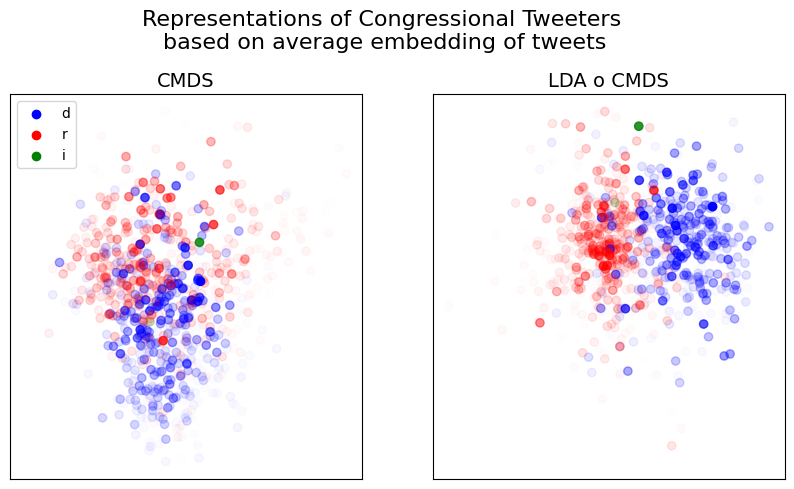

In [4]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
color_by_congress_person = [colors[p] for p in party_by_congress_person]
boldness_by_congress_person = tweets_per_congress_person / max(tweets_per_congress_person)

ax[0].scatter(cmds_embds[:, 0], cmds_embds[:, 1], 
              c=color_by_congress_person, 
              alpha=boldness_by_congress_person)
ax[0].set_title('CMDS', fontsize=14)
xlim, ylim = ax[0].get_xlim(), ax[0].get_ylim()

for label,color in colors.items():
    ax[0].scatter(1e5, 1e5, label=label, color=color)

ax[0].set_xlim(*xlim)
ax[0].set_ylim(*ylim)

ax[0].legend()

ax[1].scatter(lda_embds[:, 0], lda_embds[:, 1], c=color_by_congress_person, alpha=boldness_by_congress_person)
ax[1].set_title('LDA o CMDS', fontsize=14)

for ax_ in ax:
    ax_.set_yticks([])
    ax_.set_xticks([])

fig.suptitle('Representations of Congressional Tweeters \nbased on average embedding of tweets', fontsize=16, y=1.05)